(88, 88, 64, 170)
 img_absNav shape: (170, 88, 88, 4)
 img_reshaped shape: (30976, 170)
 Sr shape: (30976, 20)
 Ar shape: (170, 20)
 Ar shape: (170, 20)
 robica_cor: [ 0.74044084 -0.17869639]
PCA correlations: [-0.74505003  0.2228613 ]


C:\Users\march\AppData\Local\Temp\ipykernel_38940\1433881177.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


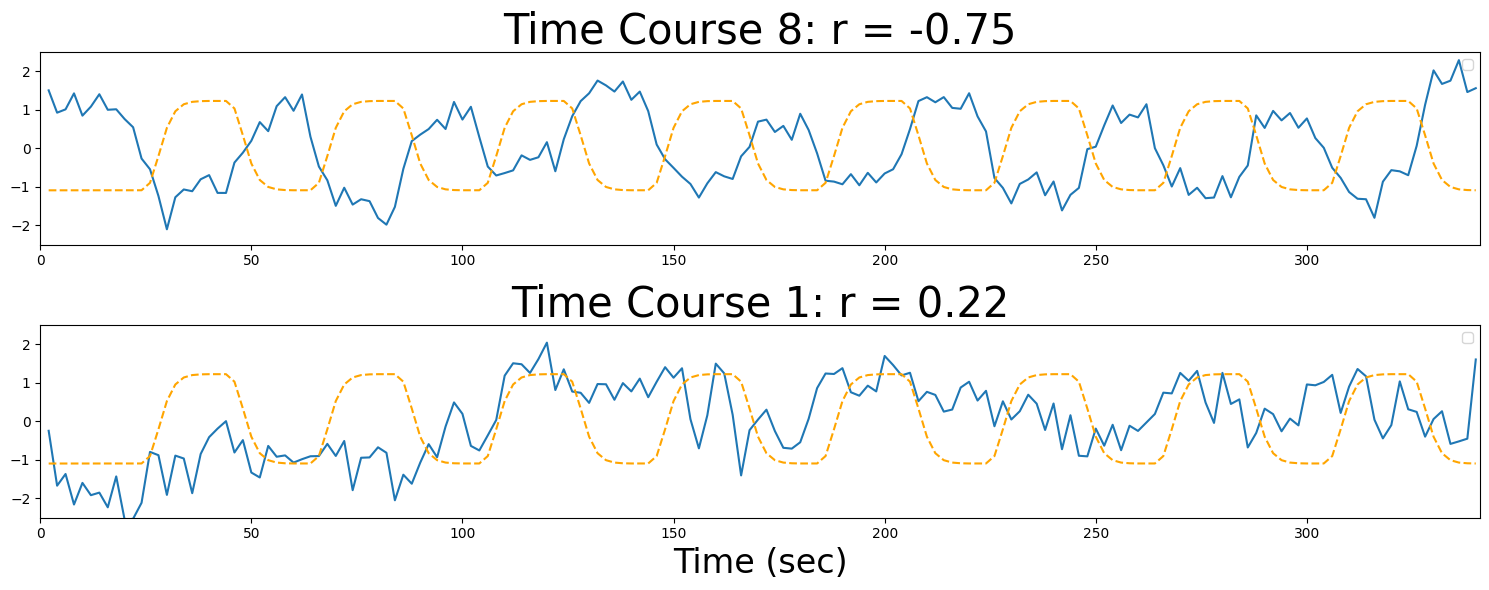

ICA correlations: [ 0.74044084 -0.17869639]


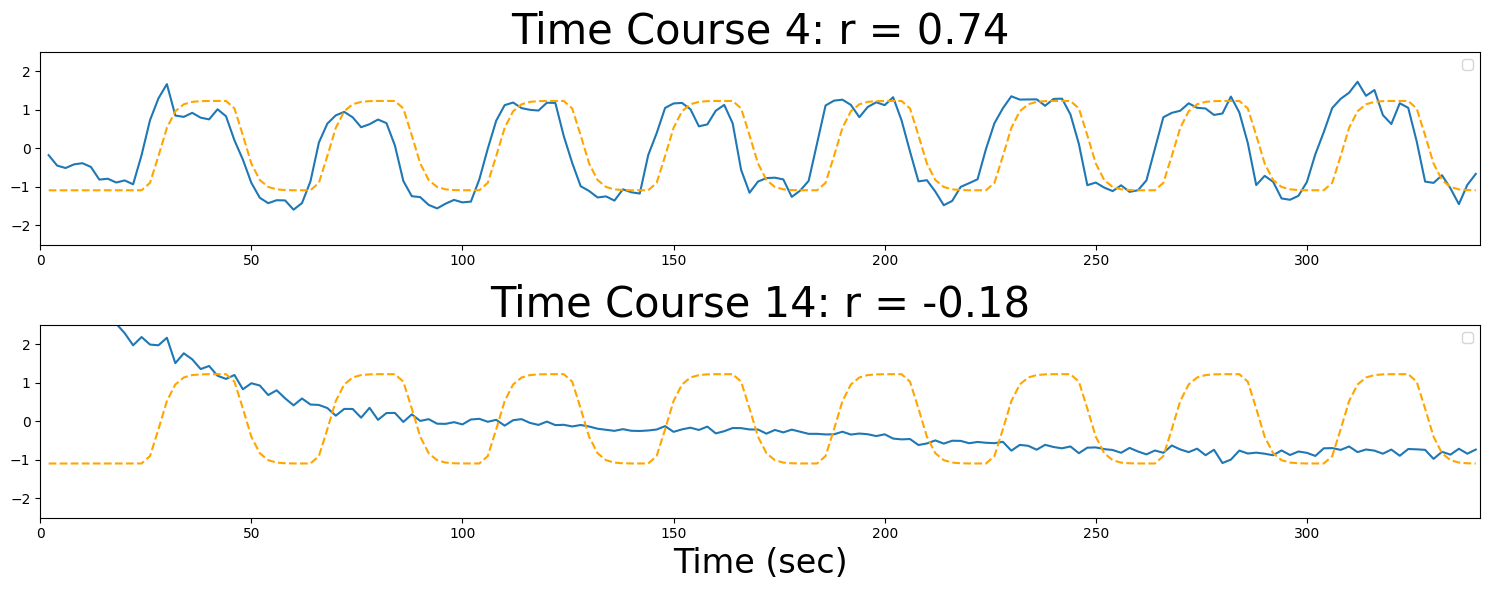

In [ ]:

import numpy as np
import scipy.io
from scipy.ndimage import zoom
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt
import sys
import os
import scipy.io
import pydicom

# Replace this with the path to the folder containing the .IMA files
folder_path = r'C:\DocumentsPC\Research2\2024_10_20RPCAICA\ICASVDNov2024\EPI_CMRR_170BR_0009'

TR = 2
# Get a list of all .IMA files in the folder
ima_files = [f for f in os.listdir(folder_path) if f.endswith('.IMA')]
# Sort the files if needed (by name) - useful if they are sequential slices
ima_files.sort()
# Initialize an empty list to store 2D image data
image_slices = []
# Loop through and read each .IMA file
for ima_file in ima_files:
    file_path = os.path.join(folder_path, ima_file)
    # print(file_path) # make sure images are in the right order.
    # Read the DICOM file
    dicom_data = pydicom.dcmread(file_path)
    
    # Extract pixel data (2D array) and append it to the list
    pixel_array = dicom_data.pixel_array
    image_slices.append(pixel_array)
# Convert the list of 2D slices to a 3D numpy array
data = np.stack(image_slices, axis=-1)


# `data` is your original 3D array of shape (704, 704, 170).
#data = magnitude_data  

# Initialize an empty array to store the 64 slices of size 88x88x170.
# The new shape will be (88, 88, 64, 170)
new_shape = (88, 88, 64, 170)
sliced_data = np.zeros(new_shape)

# Loop over the 64 slices and extract each 88x88 patch
index = 0
for i in range(0, 704, 88):
    for j in range(0, 704, 88):
        sliced_data[:, :, index, :] = data[i:i+88, j:j+88, :]
        index += 1

print(sliced_data.shape)  # Should output (88, 88, 64, 170)

# print("sliced_data slice") # test plotting a slice.
# plt.imshow(sliced_data[:,:,30,30])
# plt.show()

# Reshape magnitude data for downsampling
x1, y1, z1, t1 = sliced_data.shape

# Downsample the imaging data
# simulation of magnitude of the reconstructed navigator
factor = 1/16 # 1/8, 1/16
img_absNav = np.array([zoom(sliced_data[:, :, :, i], zoom = (1,1,factor), order=1) for i in range(t1)])
t, x, y, z = img_absNav.shape
print(f" img_absNav shape: {img_absNav.shape}")

# ICA
img_reshaped = img_absNav.reshape(t, x * y * z).T

ica = FastICA(n_components=20) # n_components=12 for 2024_11 result  # Adjust as needed for component selection
Sr = ica.fit_transform(img_reshaped) # X = S * A' or S @ A.T
Ar = ica.mixing_
print(f" img_reshaped shape: {img_reshaped.shape}")
print(f" Sr shape: {Sr.shape}")
print(f" Ar shape: {Ar.shape}")

# Plot time course comparison with task
TR = 2
time = np.arange(0, t) * TR

# Define task
from HRFtask2 import HRFtask2
onTime = 20
N_tpt = 170
#TR = 2
delay = 4
ASL = 0
plotTask = 0
task, taskdiff = HRFtask2(onTime, N_tpt, TR, delay, ASL, plotTask)
task = (task - np.mean(task)) / np.std(task)  # Normalize task

# Correlations with task
def top_correlations(A, v, C=2):
    correlations = np.array([np.corrcoef(A[:, i], v)[0, 1] for i in range(A.shape[1])])
    abs_correlations = np.abs(correlations)
    top_indices = abs_correlations.argsort()[-C:][::-1]
    return correlations[top_indices], top_indices


print(f" Ar shape: {Ar.shape}")
#print(task.shape)
robica_cor, robica_cor_ind = top_correlations(Ar, task)
print(f" robica_cor: {robica_cor}")

# # Plot components and task correlation
# plt.figure()
# for i in robica_cor_ind:
#     plt.plot(time, (Ar[:, i] - Ar[:, i].mean()) / Ar[:, i].std(), label=f'TC{i+1}')
# plt.plot(time, task, label='Task', linestyle='--')
# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Signal')
# plt.show()

# Perform PCA
pca = PCA()
U = pca.fit_transform(img_reshaped)
Sigma = pca.singular_values_
V = pca.components_.T

# Top correlations for PCA
svd_cor, svd_cor_ind = top_correlations(V, task)

import matplotlib.pyplot as plt
import math

def plot_top_correlations_with_task(V, svd_cor_ind, svd_cor, task, time_values=None):
    """
    Plots the columns of V indexed by svd_cor_ind with correlation values from svd_cor in a compact subplot layout.
    Each plot includes the 'task' variable as an overlay.

    Parameters:
    - V: 2D array or DataFrame, where each column is a function of time.
    - svd_cor_ind: List or array of indices of the top correlated columns.
    - svd_cor: List or array of correlation values for the selected columns.
    - task: 1D array or series, with the same length as time (time,).
    - time_values: Optional, the time values for the x-axis. Defaults to range based on the length of V.
    """
    # Set up time values if not provided
    if time_values is None:
        time_values = range(V.shape[0])

    # Determine the subplot grid size (e.g., sqrt for near-square layout)
    num_plots = len(svd_cor_ind)
    num_rows = math.ceil(math.sqrt(num_plots))
    num_cols = math.ceil(num_plots / num_rows)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten to easily index each subplot
    for idx, col_index in enumerate(svd_cor_ind):
        ax = axes[idx]
        # Plot the selected column of V and the task variable
        ax.plot(time_values, (V[:, col_index] - V[:, col_index].mean()) / V[:, col_index].std())
        ax.plot(time_values, task, linestyle='--', color='orange')
        ax.set_title(f'Time Course {col_index+1}: r = {svd_cor[idx]:.2f}',fontsize = 30)
        
        if  idx == len(svd_cor_ind) - 1:
            ax.set_xlabel('Time (sec)',fontsize = 24)
        # ax.set_ylabel('Signal')
        ax.legend()
        ax.set_xlim((0, 341))  # Set x-axis limit for each plot
        ax.set_ylim((-2.5, 2.5))  # Set y-axis limit for each plot
    # plt.xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)

    # Hide any unused subplots
    for j in range(idx + 1, num_rows * num_cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    # xmin, xmax = 0, 341
    # ymin, ymax = -2.8, 2.8
    # plt.xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    plt.show()


time_values = np.arange(1,task.shape[0] + 1) * TR
print(f"PCA correlations: {svd_cor}")
plot_top_correlations_with_task(V, svd_cor_ind, svd_cor, task, time_values)

print(f"ICA correlations: {robica_cor}")
plot_top_correlations_with_task(Ar, robica_cor_ind, robica_cor, task, time_values)



In [2]:
# Data denoising based on ICA/PCA components
# original
Y = sliced_data.reshape(x1 * y1 * z1, t1).T
print(f"sliced_data shape: {sliced_data.shape}")

# project Y onto basis - case 1
a, b = 1, 7 # ICs, PCs to use

# do SVD on a zeroed out IC recon, then use those components instead of the ones with the IC contamination
Sr0 = np.copy(Sr)
Sr0[:,robica_cor_ind[0]] = np.zeros_like(Sr0[:,robica_cor_ind[0]])
XnoIC = Sr0 @ Ar.T
UUnused, SUnused, Vnoic = np.linalg.svd(XnoIC, full_matrices=False)
Vnoic = Vnoic.T
S = np.hstack((Ar[:, robica_cor_ind[:a]], Vnoic[:, :b]))

Yhatr = np.dot(np.dot(S, np.linalg.pinv(np.dot(S.T, S))), np.dot(S.T, Y))
print(f"Yhatr shape: {Yhatr.shape}")

# project Y onto basis - case 2, only PCs
b2 = a+b # ICs, PCs to use
S = V[:, :b2]
print(f"S shape: {S.shape}")

Yhatpc = np.dot(np.dot(S, np.linalg.pinv(np.dot(S.T, S))), np.dot(S.T, Y))
print(f"Yhatpc shape: {Yhatpc.shape}")

# Apply GLM
fwhm, q, voxel_dims = 0, 0.05, [2.5, 2.5, 2.5]
X = np.column_stack((np.ones(len(task)), task))

# Function stubs for GLM and other custom functions
from FDRBHact import FDRBHact

# GLM processing
from scipy.ndimage import gaussian_filter
filtersigma = [.5,.5,.5,0]
smoothed_img = gaussian_filter(sliced_data, sigma=filtersigma)
log10p_orig = FDRBHact(smoothed_img, fwhm, q, X,)[:, :, :, 1]

smoothed_img = gaussian_filter(Yhatr.T.reshape((x1, y1, z1, t1)), sigma=filtersigma)
log10p_combo = FDRBHact(smoothed_img, fwhm, q, X,)[:, :, :, 1]

smoothed_img = gaussian_filter(Yhatpc.T.reshape((x1, y1, z1, t1)), sigma=filtersigma)
log10p_pca = FDRBHact(smoothed_img, fwhm, q, X)[:, :, :, 1]


sliced_data shape: (88, 88, 64, 170)
Yhatr shape: (170, 495616)
S shape: (170, 8)
Yhatpc shape: (170, 495616)


c:\DocumentsPC\Research2\2024_10_20RPCAICA\ICASVDNov2024\beta_to_tscore.py:39: RuntimeWarning: invalid value encountered in divide
  t_scores = beta / SE


C:\Users\march\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\nilearn\plotting\img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


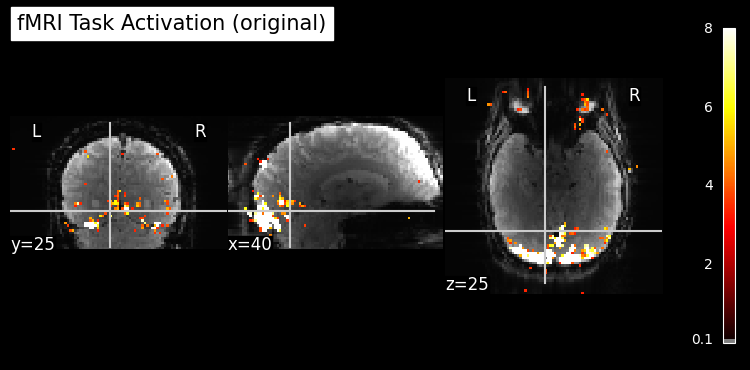

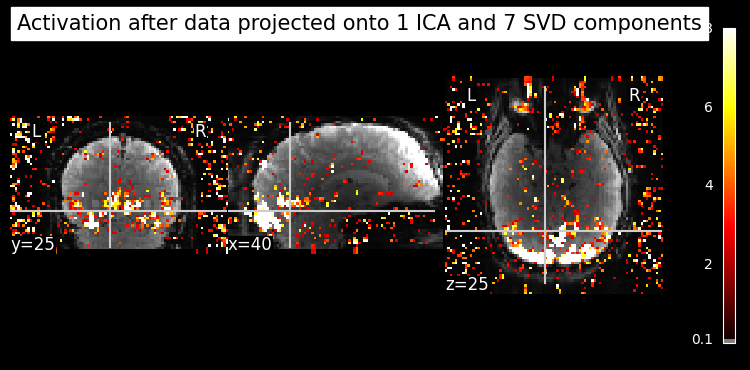

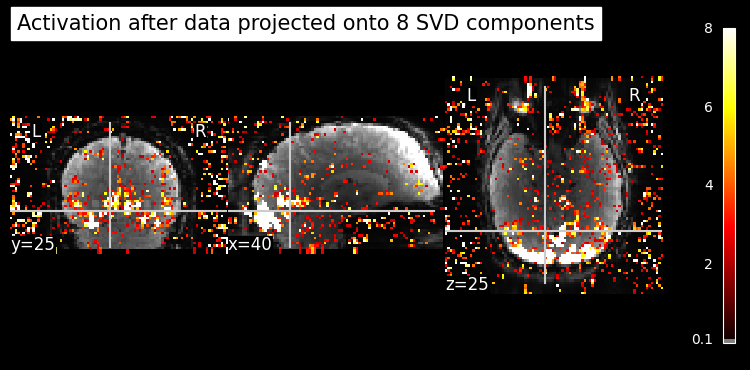

In [3]:
# plot figures:
#!pip install nilearn nibabel

from nilearn import plotting, image
import nibabel as nib
affine = np.eye(4)
anat_data = np.mean(sliced_data, axis=3)


act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_orig, (0,1,2)),3),axis=2), affine)
anat_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(anat_data, (0,1,2)),3),axis=2), affine)
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title=f'fMRI Task Activation (original)',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)


act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_combo, (0,1,2)),3),axis=2), affine)
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title=f'Activation after data projected onto {a} ICA and {b} SVD components',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)


act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_pca, (0,1,2)),3),axis=2), affine)
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title=f'Activation after data projected onto {b2} SVD components',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)




